In [ ]:
import keras
import tensorflow as tf
tf.keras.backend.clear_session()
from keras.models import Sequential
from keras import layers
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Bidirectional, Dense

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = input("Enter the path to the CSV file: ")
dataset = pd.read_csv(file_path, header=0, encoding='Latin', engine='python')
#dataset= pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv",header = 0, encoding = 'Latin', engine = 'python')
dataset.head()

Enter the path to the CSV file: /content/drive/MyDrive/IMDB Dataset.csv


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
dataset['sentiment'] = dataset['sentiment'].replace('positive', 1)
dataset['sentiment'] = dataset['sentiment'].replace('negative', 0)

In [ ]:
glovepathinput = input("Enter the path to the gloVe file: ")
glove_path = glovepathinput

Enter the path to the gloVe file: /content/drive/MyDrive/glove.6B.100d.txt


In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
x = dataset['review']
y = dataset['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1000)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(x_train[2])
print(X_train_seq[2])

I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.
[5, 94, 3, 19, 34839, 1, 18771, 2, 1, 144, 326, 1671, 2515, 59, 6982, 57,

In [ ]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(glove_path,tokenizer.word_index, embedding_dim)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.6250912002847229

In [ ]:
from keras import backend as K
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = K.clip(true_positives / (predicted_positives + K.epsilon()), 0, 1)
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = K.clip(true_positives / (possible_positives + K.epsilon()), 0, 1)
    return recall

def f1score_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = K.clip(true_positives / (possible_positives + K.epsilon()), 0, 1)

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = K.clip(true_positives / (predicted_positives + K.epsilon()), 0, 1)

    if precision + recall == 0:
        f1_score = K.constant(0)
    else:
        f1_score = K.clip(2 * (precision * recall) / (precision + recall), 0, 1)

    return f1_score


In [ ]:
batch_sizes_to_try = [16, 32, 64, 128, 256]
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)
for batch_size in batch_sizes_to_try:
    print(f"\nTraining with batch size: {batch_size}")


    shallow_model = Sequential()
    shallow_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length, weights=[embedding_matrix], trainable=False))
    shallow_model.add(Dense(10, activation='relu'))
    shallow_model.add(Dense(1, activation='sigmoid'))
    shallow_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train
    history = shallow_model.fit(X_train_pad, y_train, epochs=20, batch_size=batch_size, validation_split=0.1, verbose=0)

    # Evaluate
    loss, accuracy = shallow_model.evaluate(X_test_pad, y_test)
    print(f'Test Accuracy (Batch Size {batch_size}): {accuracy * 100:.2f}%')


Training with batch size: 16
313/313 [==============================] - 1s 3ms/step - loss: 0.6824 - accuracy: 0.5466
Test Accuracy (Batch Size 16): 54.66%

Training with batch size: 32
313/313 [==============================] - 1s 3ms/step - loss: 0.6833 - accuracy: 0.5453
Test Accuracy (Batch Size 32): 54.53%

Training with batch size: 64
313/313 [==============================] - 1s 3ms/step - loss: 0.6831 - accuracy: 0.5466
Test Accuracy (Batch Size 64): 54.66%

Training with batch size: 128
313/313 [==============================] - 1s 4ms/step - loss: 0.6836 - accuracy: 0.5458
Test Accuracy (Batch Size 128): 54.58%

Training with batch size: 256
313/313 [==============================] - 1s 3ms/step - loss: 0.6839 - accuracy: 0.5444
Test Accuracy (Batch Size 256): 54.44%


In [ ]:
model = Sequential()
maxlen = 100
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen,  trainable=True))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',precision_m,recall_m,f1score_m])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          11239000  
                                                                 
 dense_12 (Dense)            (None, 100, 10)           1010      
                                                                 
 dense_13 (Dense)            (None, 100, 1)            11        
                                                                 
Total params: 11240021 (42.88 MB)
Trainable params: 11240021 (42.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
max_length = 100

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)
model.fit(X_train_pad, y_train, epochs=20, batch_size=16, validation_split=0.1)


Epoch 1/20
563/563 [==============================] - 168s 291ms/step - loss: 0.6867 - accuracy: 0.5444 - precision_m: 0.5466 - recall_m: 1.0000 - f1score_m: 0.7042 - val_loss: 0.6811 - val_accuracy: 0.5482 - val_precision_m: 0.5844 - val_recall_m: 1.0000 - val_f1score_m: 0.7362
Epoch 2/20
563/563 [==============================] - 176s 313ms/step - loss: 0.6762 - accuracy: 0.5625 - precision_m: 0.5645 - recall_m: 1.0000 - f1score_m: 0.7193 - val_loss: 0.6776 - val_accuracy: 0.5591 - val_precision_m: 0.5575 - val_recall_m: 1.0000 - val_f1score_m: 0.7143
Epoch 3/20
563/563 [==============================] - 173s 307ms/step - loss: 0.6733 - accuracy: 0.5646 - precision_m: 0.5660 - recall_m: 1.0000 - f1score_m: 0.7206 - val_loss: 0.6779 - val_accuracy: 0.5590 - val_precision_m: 0.5496 - val_recall_m: 1.0000 - val_f1score_m: 0.7078
Epoch 4/20
563/563 [==============================] - 171s 303ms/step - loss: 0.6710 - accuracy: 0.5669 - precision_m: 0.5682 - recall_m: 1.0000 - f1score_m: 0.

KeyboardInterrupt: ignored

In [ ]:
shallow_evaluation = model.evaluate(X_train_pad, y_train)
print("Training:")
metric_names = model.metrics_names


for metric_name, metric_value in zip(metric_names, shallow_evaluation):
    print(f"{metric_name.capitalize()}: {metric_value}")

shallow_evaluation = model.evaluate(X_test_pad, y_test)
print("Testing:")
metric_names = model.metrics_names


for metric_name, metric_value in zip(metric_names, shallow_evaluation):
    print(f"{metric_name.capitalize()}: {metric_value}")

In [ ]:
#LSTM

In [ ]:
model_lstm_uni = Sequential()
model_lstm_uni.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length, weights=[embedding_matrix], trainable=False))
model_lstm_uni.add(LSTM(10))
model_lstm_uni.add(Dense(1, activation='sigmoid'))
model_lstm_uni.summary()

In [ ]:
model_lstm_uni.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1score_m])
model_lstm_uni.fit(X_train_pad, y_train, epochs=20, batch_size=16, validation_split=0.1)

Epoch 1/20
1125/1125 [==============================] - 12s 8ms/step - loss: 0.5357 - accuracy: 0.7241 - precision_m: 0.7324 - recall_m: 0.7299 - f1score_m: 0.7161 - val_loss: 0.4416 - val_accuracy: 0.8008 - val_precision_m: 0.8155 - val_recall_m: 0.7793 - val_f1score_m: 0.7915
Epoch 2/20
1125/1125 [==============================] - 10s 9ms/step - loss: 0.4269 - accuracy: 0.8044 - precision_m: 0.8094 - recall_m: 0.8037 - f1score_m: 0.7985 - val_loss: 0.4090 - val_accuracy: 0.8183 - val_precision_m: 0.7992 - val_recall_m: 0.8524 - val_f1score_m: 0.8201
Epoch 3/20
1125/1125 [==============================] - 9s 8ms/step - loss: 0.3953 - accuracy: 0.8195 - precision_m: 0.8217 - recall_m: 0.8196 - f1score_m: 0.8138 - val_loss: 0.3856 - val_accuracy: 0.8330 - val_precision_m: 0.8290 - val_recall_m: 0.8417 - val_f1score_m: 0.8309
Epoch 4/20
1125/1125 [==============================] - 8s 7ms/step - loss: 0.3763 - accuracy: 0.8294 - precision_m: 0.8329 - recall_m: 0.8283 - f1score_m: 0.8239 -

In [ ]:
lstm_uni_evaluation = model_lstm_uni.evaluate(X_train_pad, y_train)
print("Training")
metric_names = model_lstm_uni.metrics_names
for metric_name, metric_value in zip(metric_names, lstm_uni_evaluation):
    print(f"{metric_name.capitalize()}: {metric_value}")

lstm_uni_evaluation = model_lstm_uni.evaluate(X_test_pad, y_test)
print("Testing")
metric_names = model_lstm_uni.metrics_names
for metric_name, metric_value in zip(metric_names, lstm_uni_evaluation):
    print(f"{metric_name.capitalize()}: {metric_value}")

1250/1250 [==============================] - 5s 4ms/step - loss: 0.2694 - accuracy: 0.8868 - precision_m: 0.8795 - recall_m: 0.8975 - f1score_m: 0.8850
Training
Loss: 0.26944881677627563
Accuracy: 0.8868250250816345
Precision_m: 0.8794683814048767
Recall_m: 0.8975121974945068
F1score_m: 0.8850035071372986
313/313 [==============================] - 42s 6ms/step - loss: 0.3462 - accuracy: 0.8502 - precision_m: 0.8358 - recall_m: 0.8645 - f1score_m: 0.8464
Testing
Loss: 0.34619536995887756
Accuracy: 0.8501999974250793
Precision_m: 0.8357941508293152
Recall_m: 0.8644694089889526
F1score_m: 0.8464212417602539


In [ ]:
#Bidirectional
model_lstm_bi = Sequential()
model_lstm_bi.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length, weights=[embedding_matrix], trainable=False))
model_lstm_bi.add(Bidirectional(LSTM(10)))
model_lstm_bi.add(Dense(1, activation='sigmoid'))
model_lstm_bi.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 100, 100)          11239000  
                                                                 
 bidirectional_1 (Bidirecti  (None, 20)                8880      
 onal)                                                           
                                                                 
 dense_36 (Dense)            (None, 1)                 21        
                                                                 
Total params: 11247901 (42.91 MB)
Trainable params: 8901 (34.77 KB)
Non-trainable params: 11239000 (42.87 MB)
_________________________________________________________________


In [ ]:
model_lstm_bi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',precision_m, recall_m, f1score_m])
model_lstm_bi.fit(X_train_pad, y_train, epochs=20, batch_size=16, validation_split=0.1)

Epoch 1/20
1125/1125 [==============================] - 17s 12ms/step - loss: 0.5316 - accuracy: 0.7266 - precision_m: 0.7384 - recall_m: 0.7309 - f1score_m: 0.7207 - val_loss: 0.4413 - val_accuracy: 0.7975 - val_precision_m: 0.8409 - val_recall_m: 0.7332 - val_f1score_m: 0.7787
Epoch 2/20
1125/1125 [==============================] - 13s 11ms/step - loss: 0.4172 - accuracy: 0.8074 - precision_m: 0.8157 - recall_m: 0.8005 - f1score_m: 0.8012 - val_loss: 0.3977 - val_accuracy: 0.8175 - val_precision_m: 0.8008 - val_recall_m: 0.8421 - val_f1score_m: 0.8170
Epoch 3/20
1125/1125 [==============================] - 13s 12ms/step - loss: 0.3830 - accuracy: 0.8266 - precision_m: 0.8304 - recall_m: 0.8239 - f1score_m: 0.8207 - val_loss: 0.3695 - val_accuracy: 0.8317 - val_precision_m: 0.8295 - val_recall_m: 0.8345 - val_f1score_m: 0.8283
Epoch 4/20
1125/1125 [==============================] - 14s 13ms/step - loss: 0.3632 - accuracy: 0.8378 - precision_m: 0.8439 - recall_m: 0.8350 - f1score_m: 0.

In [ ]:
lstm_bi_evaluation = model_lstm_bi.evaluate(X_train_pad, y_train)
print("Traning")
metric_names = model_lstm_bi.metrics_names
for metric_name, metric_value in zip(metric_names, lstm_bi_evaluation):
    print(f"{metric_name.capitalize()}: {metric_value}")

lstm_bi_evaluation = model_lstm_bi.evaluate(X_test_pad, y_test)
print("Testing")
metric_names = model_lstm_bi.metrics_names
for metric_name, metric_value in zip(metric_names, lstm_bi_evaluation):
    print(f"{metric_name.capitalize()}: {metric_value}")

1250/1250 [==============================] - 8s 6ms/step - loss: 0.2317 - accuracy: 0.9043 - precision_m: 0.9159 - recall_m: 0.8916 - f1score_m: 0.9009
Traning
Loss: 0.23173201084136963
Accuracy: 0.904325008392334
Precision_m: 0.915909469127655
Recall_m: 0.8916433453559875
F1score_m: 0.9008693099021912
313/313 [==============================] - 2s 5ms/step - loss: 0.3523 - accuracy: 0.8515 - precision_m: 0.8602 - recall_m: 0.8334 - f1score_m: 0.8424
Testing
Loss: 0.35232317447662354
Accuracy: 0.8514999747276306
Precision_m: 0.860238254070282
Recall_m: 0.8334054946899414
F1score_m: 0.8423897624015808


In [ ]:
#Comparison

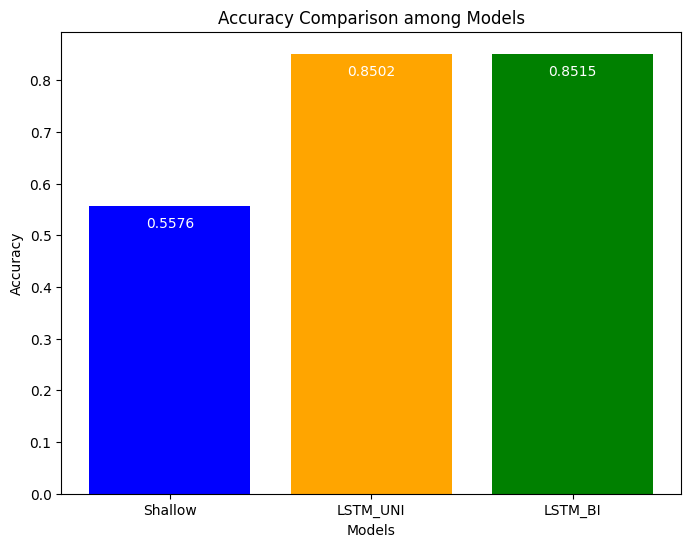

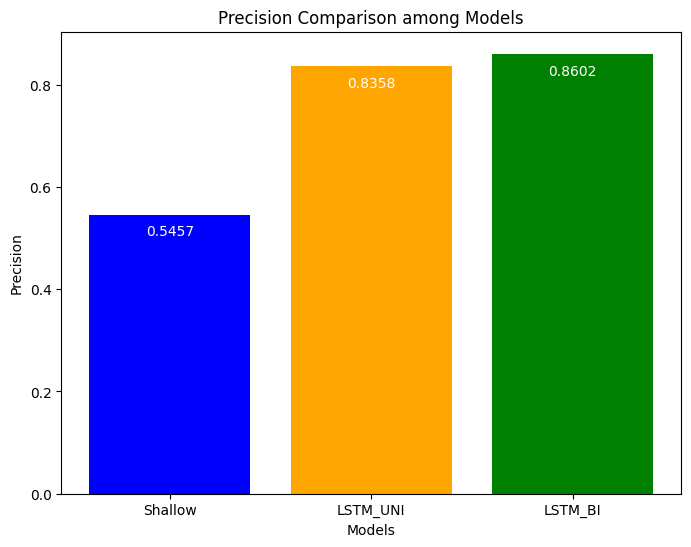

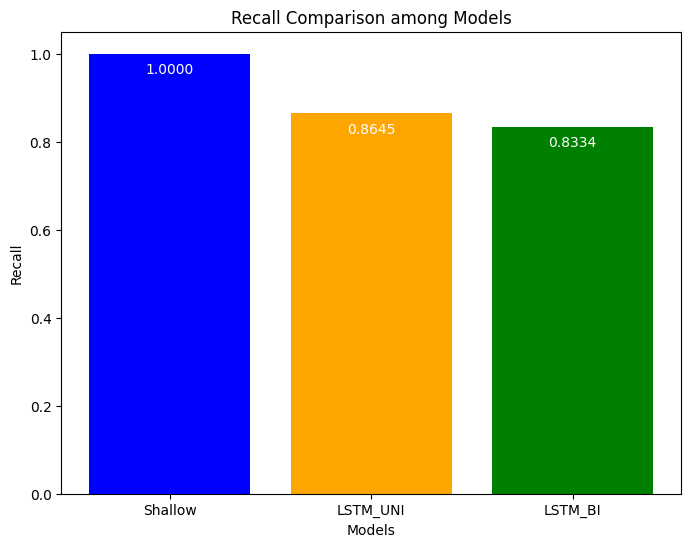

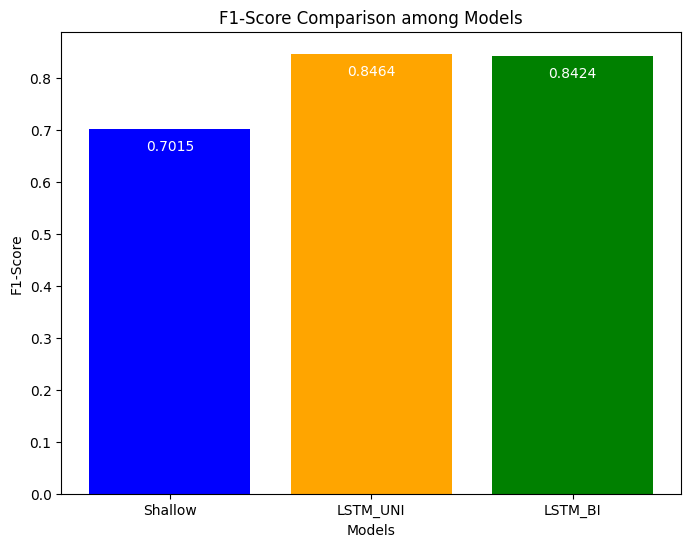

In [ ]:
models = ['Shallow', 'LSTM_UNI', 'LSTM_BI']
accuracy = [shallow_evaluation[1], lstm_uni_evaluation[1], lstm_bi_evaluation[1]]
precision = [shallow_evaluation[2], lstm_uni_evaluation[2], lstm_bi_evaluation[2]]
recall = [shallow_evaluation[3], lstm_uni_evaluation[3], lstm_bi_evaluation[3]]
f1_score = [shallow_evaluation[4], lstm_uni_evaluation[4], lstm_bi_evaluation[4]]

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_values = [accuracy, precision, recall, f1_score]

for i, metric in enumerate(metrics):
    plt.figure(figsize=(8, 6))
    bars = plt.bar(models, metric_values[i], color=['blue', 'orange', 'green'])


    for bar, value in zip(bars, metric_values[i]):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02, f'{value:.4f}', ha='center', va='top', color='white')

    plt.xlabel('Models')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison among Models')
    plt.show()